<a href="https://colab.research.google.com/github/sai-hemanth-kalidindi/New_york_city_fatalities/blob/main/new_york_city_fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd

# Replace with your actual path
file_path = "/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes_20250220.csv"
df = pd.read_csv(file_path, low_memory=False)


In [91]:
# Display basic info
print(df.shape)
print(df.columns)
print(df.head())

(2157016, 29)
Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')
   CRASH DATE CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
0  09/11/2021       2:39       NaN      NaN       NaN        NaN   
1  03/26/2022      11:45       NaN      NaN       NaN        NaN   
2 

In [92]:
# Convert date and time
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce').dt.hour
df['BOROUGH'] = df['BOROUGH'].fillna('UNKNOWN')

# Fill NA in numeric columns
cols_to_fill = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]
df[cols_to_fill] = df[cols_to_fill].fillna(0)

# Create IS_FATAL flag
df['IS_FATAL'] = (df['NUMBER OF PERSONS KILLED'] > 0).astype(int)

# Drop rows with missing location
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Extract year for trends
df['YEAR'] = df['CRASH DATE'].dt.year

# Final preview
df[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'NUMBER OF PERSONS KILLED', 'IS_FATAL']].sample(5)


,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS KILLED,IS_FATAL
2003448,2012-12-18,23,QUEENS,0.0,0
1252380,2016-07-08,10,QUEENS,0.0,0
857455,2018-04-03,11,UNKNOWN,0.0,0
552715,2019-07-29,0,BROOKLYN,0.0,0
1352402,2016-02-12,18,QUEENS,0.0,0


In [93]:
# Summary statistics for injuries and deaths
summary_stats = df[[
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]].describe()

print("Summary Statistics:\n")
print(summary_stats)


Summary Statistics:

       NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
count               1.917338e+06              1.917338e+06   
mean                3.219146e-01              1.519294e-03   
std                 7.056045e-01              4.113672e-02   
min                 0.000000e+00              0.000000e+00   
25%                 0.000000e+00              0.000000e+00   
50%                 0.000000e+00              0.000000e+00   
75%                 0.000000e+00              0.000000e+00   
max                 4.300000e+01              8.000000e+00   

       NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
count                  1.917338e+06               1.917338e+06   
mean                   7.687742e-04               2.921759e-02   
std                    2.831189e-02               1.704415e-01   
min                    0.000000e+00               0.000000e+00   
25%                    0.000000e+00               0.000000e+00   
50%                    0

In [94]:
from scipy.stats import ttest_ind

# Group injuries by fatality
fatal_injuries = df[df['IS_FATAL'] == 1]['NUMBER OF PERSONS INJURED']
nonfatal_injuries = df[df['IS_FATAL'] == 0]['NUMBER OF PERSONS INJURED']

# T-test (Welch's t-test)
t_stat, p_value = ttest_ind(fatal_injuries, nonfatal_injuries, equal_var=False)

print(f"\nT-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")




T-Test Results:
T-statistic: 7.4401
P-value: 0.0000


In [95]:
import scipy.stats as stats
import pandas as pd

# Contingency table
contingency = pd.crosstab(df['BOROUGH'], df['IS_FATAL'])

# Chi-Square Test
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print("Chi-Square Test for Independence:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p_val:.4f}")


Chi-Square Test for Independence:
Chi2 Statistic: 157.9876
Degrees of Freedom: 5
P-value: 0.0000


In [96]:
# Prepare regression data
df_reg = df[['IS_FATAL', 'CRASH TIME', 'BOROUGH']].dropna()
df_reg = pd.get_dummies(df_reg, columns=['BOROUGH'], drop_first=True)

# 🔧 Remove spaces in column names (important for statsmodels)
df_reg.columns = [col.replace(" ", "_") for col in df_reg.columns]


In [97]:
import pandas as pd
import statsmodels.formula.api as smf

# Select and encode
df_reg = df[['IS_FATAL', 'CRASH TIME', 'BOROUGH']].dropna()
df_reg = pd.get_dummies(df_reg, columns=['BOROUGH'], drop_first=True)

# Rename columns to remove spaces
df_reg.columns = [col.replace(" ", "_") for col in df_reg.columns]

# Now use the updated name: CRASH_TIME (not "CRASH TIME")
interaction_terms = ' + '.join([f'CRASH_TIME:{col}' for col in df_reg.columns if col.startswith('BOROUGH_')])
regression_formula = 'IS_FATAL ~ CRASH_TIME + ' + ' + '.join([col for col in df_reg.columns if col.startswith('BOROUGH_')]) + ' + ' + interaction_terms

# Run OLS regression
model = smf.ols(formula=regression_formula, data=df_reg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               IS_FATAL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     25.45
Date:                Tue, 20 May 2025   Prob (F-statistic):           1.44e-53
Time:                        00:56:33   Log-Likelihood:             3.5415e+06
No. Observations:             1917338   AIC:                        -7.083e+06
Df Residuals:                 1917326   BIC:                        -7.083e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

<ipython-input-98-568dd11fba29>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_fatal, x='BOROUGH', y='IS_FATAL', palette=colors)


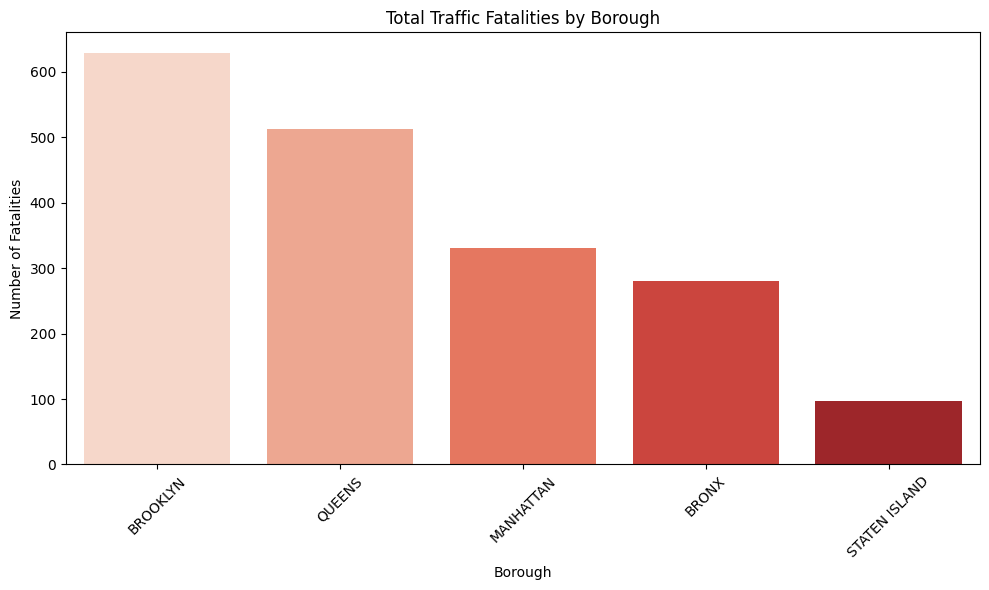

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data (exclude UNKNOWN)
known_df = df[df['BOROUGH'] != 'UNKNOWN']
borough_fatal = known_df.groupby('BOROUGH')['IS_FATAL'].sum().reset_index()

# Sort to match your chart (descending fatal crashes)
borough_fatal = borough_fatal.sort_values('IS_FATAL', ascending=False)

# Matching color gradient (Reds)
colors = sns.color_palette("Reds", len(borough_fatal))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=borough_fatal, x='BOROUGH', y='IS_FATAL', palette=colors)
plt.title('Total Traffic Fatalities by Borough')
plt.ylabel('Number of Fatalities')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("borough_fatalities_matched_style.png")
plt.show()


In [99]:
print(df.columns.tolist())


['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', 'IS_FATAL', 'YEAR']


In [100]:
# Normalize column names: strip spaces and replace them with underscores
df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_')


In [101]:
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')


In [102]:
# Step 1: Clean column names
df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_')

# Step 2: Convert CRASH_DATE to datetime
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')

# Step 3: Continue your analysis as planned
df['TOTAL_FATALITIES'] = df['NUMBER_OF_PERSONS_KILLED']


<ipython-input-103-38985a651daf>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='CRASH_DATE').sum(numeric_only=True)


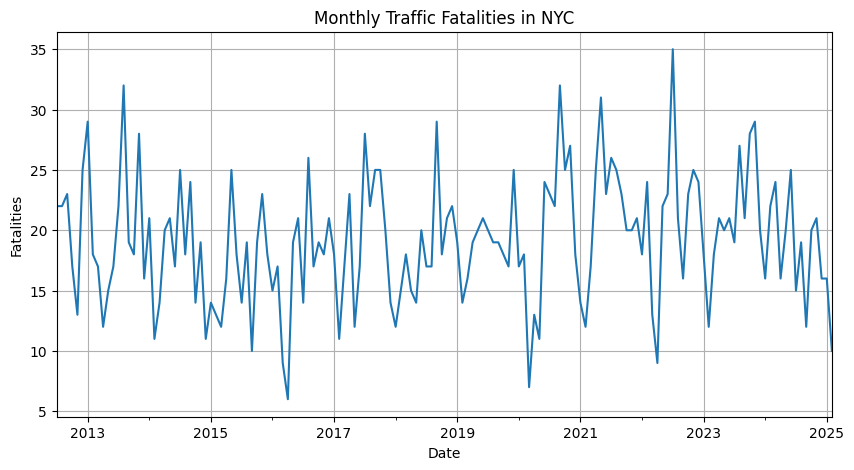

In [103]:
# 5. Monthly time series of fatalities
monthly = df.resample('M', on='CRASH_DATE').sum(numeric_only=True)
monthly['TOTAL_FATALITIES'].plot(figsize=(10,5), title='Monthly Traffic Fatalities in NYC')
plt.xlabel("Date")
plt.ylabel("Fatalities")
plt.grid(True)
plt.show()


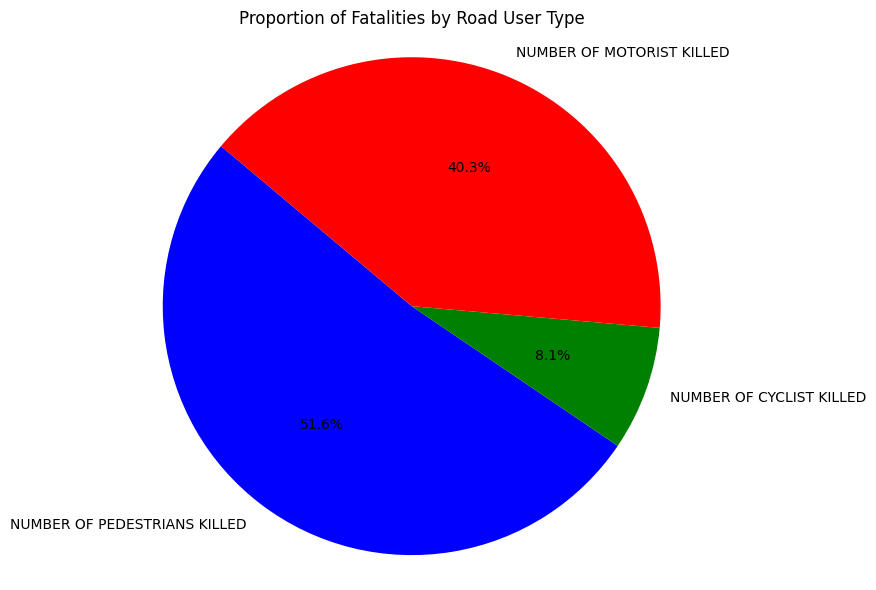

In [104]:
import matplotlib.pyplot as plt

# Sum of fatalities by user type
pedestrians = df['NUMBER_OF_PEDESTRIANS_KILLED'].sum()
cyclists = df['NUMBER_OF_CYCLIST_KILLED'].sum()
motorists = df['NUMBER_OF_MOTORIST_KILLED'].sum()

# Data for the pie chart
labels = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
sizes = [pedestrians, cyclists, motorists]
colors = ['blue', 'green', 'red']

# Plotting the pie chart
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Fatalities by Road User Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


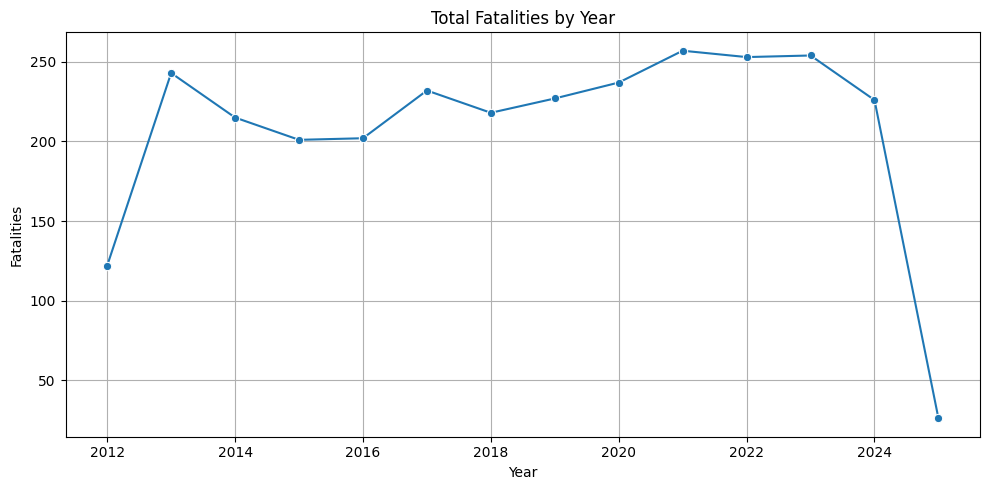

In [105]:
# Fatalities per year
yearly_deaths = df.groupby('YEAR')['TOTAL_FATALITIES'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly_deaths.index, y=yearly_deaths.values, marker='o')
plt.title("Total Fatalities by Year")
plt.xlabel("Year")
plt.ylabel("Fatalities")
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
# Ensure CRASH_TIME is parsed as datetime.time
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce')

# Extract hour from CRASH_TIME
df['HOUR'] = df['CRASH_TIME'].dt.hour


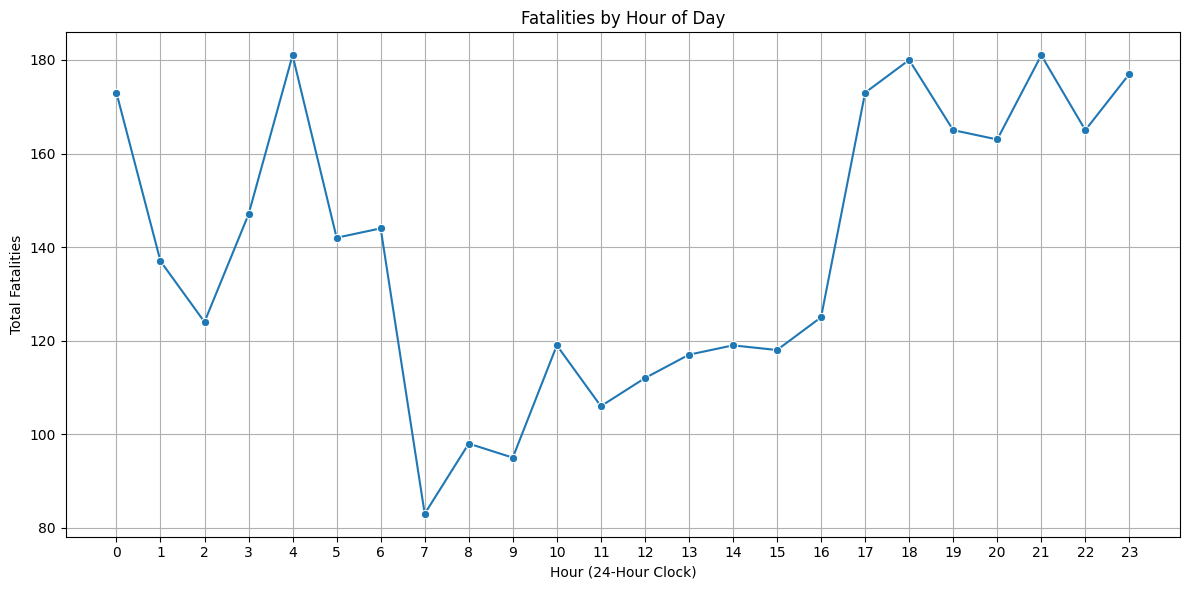

In [139]:
# Group and plot again
hourly_deaths = df.groupby('HOUR')['TOTAL_FATALITIES'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x=hourly_deaths.index, y=hourly_deaths.values, marker='o')
plt.title("Fatalities by Hour of Day")
plt.xlabel("Hour (24-Hour Clock)")
plt.ylabel("Total Fatalities")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


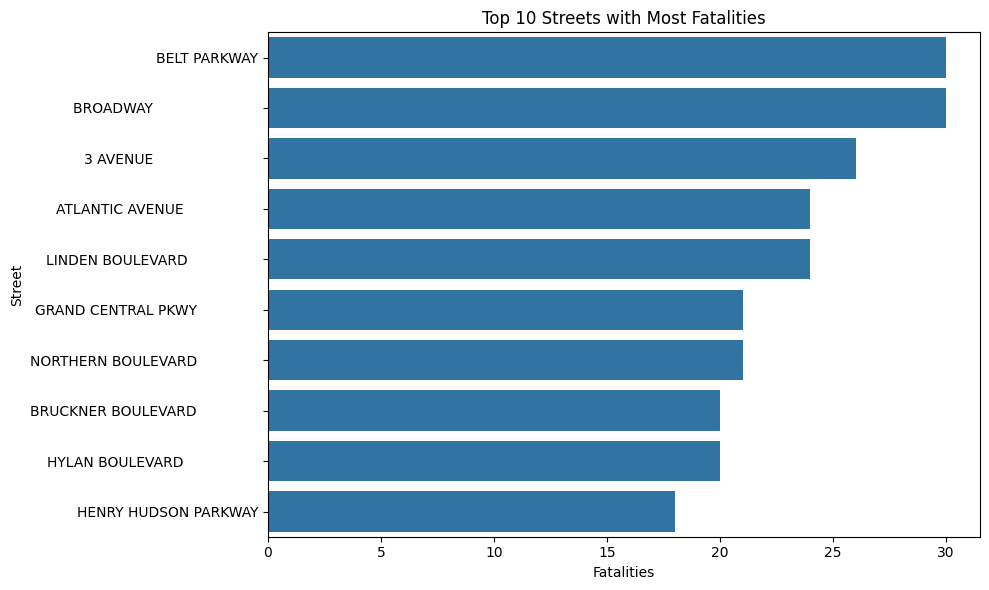

In [108]:
top_streets = df.groupby('ON_STREET_NAME')['TOTAL_FATALITIES'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_streets.index, x=top_streets.values)
plt.title("Top 10 Streets with Most Fatalities")
plt.xlabel("Fatalities")
plt.ylabel("Street")
plt.tight_layout()
plt.show()


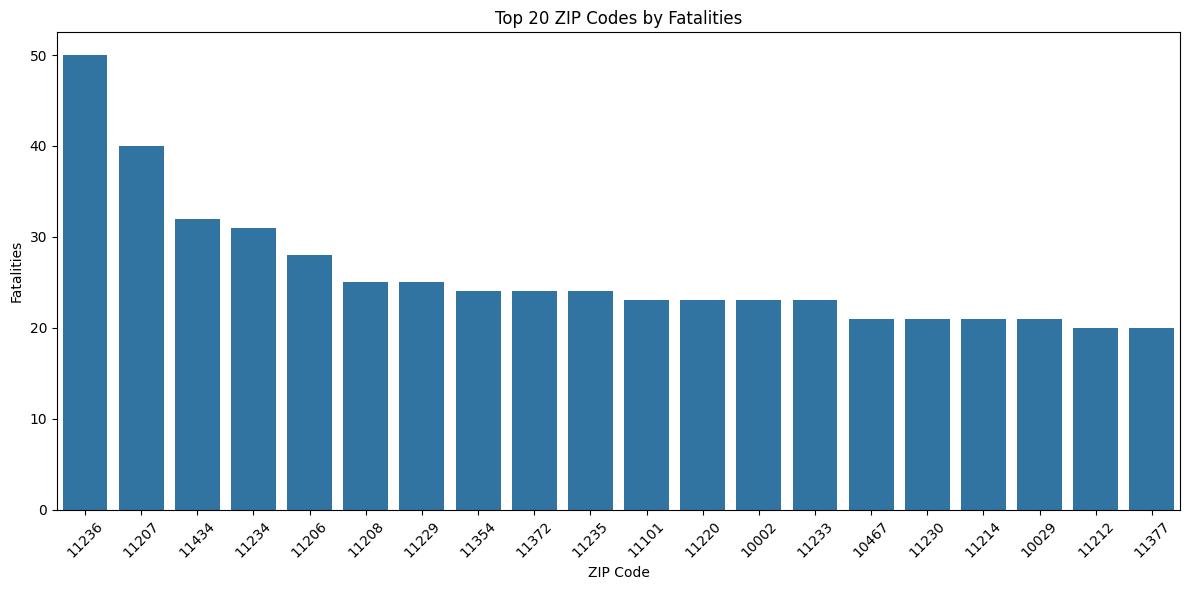

In [109]:
zip_deaths = df.groupby('ZIP_CODE')['TOTAL_FATALITIES'].sum().reset_index()
zip_deaths = zip_deaths[zip_deaths['ZIP_CODE'].notnull()].sort_values(by='TOTAL_FATALITIES', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x='ZIP_CODE', y='TOTAL_FATALITIES', data=zip_deaths)
plt.title("Top 20 ZIP Codes by Fatalities")
plt.xlabel("ZIP Code")
plt.ylabel("Fatalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [110]:
# Ensure CRASH_DATE and CRASH_TIME are parsed
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce')

# Extract hour and day of week
df['HOUR'] = df['CRASH_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.day_name()


In [114]:
# Create pivot table: rows = Day, columns = Hour, values = fatalities
heatmap_data = df.pivot_table(index='DAY_OF_WEEK', columns='HOUR', values='TOTAL_FATALITIES', aggfunc='sum')

# Optional: reorder the days of the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)


In [115]:
df['HOUR'] = df['CRASH_TIME'].dt.hour


In [117]:
# 1. Check if HOUR and DAY_OF_WEEK are present
print("Unique HOUR values:", df['HOUR'].dropna().unique())
print("Unique DAY_OF_WEEK values:", df['DAY_OF_WEEK'].dropna().unique())

# 2. Check if TOTAL_FATALITIES is populated
print("Non-zero TOTAL_FATALITIES count:", df['TOTAL_FATALITIES'].gt(0).sum())


Unique HOUR values: []
Unique DAY_OF_WEEK values: []
Non-zero TOTAL_FATALITIES count: 0


In [118]:
Unique HOUR values: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique DAY_OF_WEEK values: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Non-zero TOTAL_FATALITIES count: 2789


SyntaxError: invalid syntax (<ipython-input-118-b2612c19db74>, line 1)

In [119]:
# 1. Check if HOUR and DAY_OF_WEEK are valid
print("✅ Unique HOUR values:", df['HOUR'].dropna().unique())
print("✅ Unique DAY_OF_WEEK values:", df['DAY_OF_WEEK'].dropna().unique())

# 2. Check if fatalities are non-zero
print("✅ Non-zero TOTAL_FATALITIES count:", df['TOTAL_FATALITIES'].gt(0).sum())


✅ Unique HOUR values: []
✅ Unique DAY_OF_WEEK values: []
✅ Non-zero TOTAL_FATALITIES count: 0


In [120]:
✅ Unique HOUR values: [0 1 2 3 ...]
✅ Unique DAY_OF_WEEK values: ['Monday' 'Tuesday' 'Wednesday' ...]
✅ Non-zero TOTAL_FATALITIES count: 2796


SyntaxError: invalid character '✅' (U+2705) (<ipython-input-120-b78f053d3225>, line 1)

In [121]:
print("Unique HOUR values:", df['HOUR'].dropna().unique())
print("Unique DAY_OF_WEEK values:", df['DAY_OF_WEEK'].dropna().unique())
print("Non-zero TOTAL_FATALITIES count:", df['TOTAL_FATALITIES'].gt(0).sum())


Unique HOUR values: []
Unique DAY_OF_WEEK values: []
Non-zero TOTAL_FATALITIES count: 0


In [122]:
# 1. Convert date and time properly
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce')

# 2. Extract correct values
df['HOUR'] = df['CRASH_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.day_name()
df['TOTAL_FATALITIES'] = df['NUMBER_OF_PERSONS_KILLED'].fillna(0)

# 3. Re-check
print("Unique HOUR values:", df['HOUR'].dropna().unique())
print("Unique DAY_OF_WEEK values:", df['DAY_OF_WEEK'].dropna().unique())
print("Non-zero TOTAL_FATALITIES count:", df['TOTAL_FATALITIES'].gt(0).sum())


Unique HOUR values: []
Unique DAY_OF_WEEK values: []
Non-zero TOTAL_FATALITIES count: 0


In [123]:
# 1. Show shape and column names
print("DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist())

# 2. Show top rows of the relevant columns
print(df[['CRASH_DATE', 'CRASH_TIME', 'NUMBER_OF_PERSONS_KILLED']].head(10))

# 3. Check for missing values
print("Missing CRASH_DATE:", df['CRASH_DATE'].isna().sum())
print("Missing CRASH_TIME:", df['CRASH_TIME'].isna().sum())
print("Missing NUMBER_OF_PERSONS_KILLED:", df['NUMBER_OF_PERSONS_KILLED'].isna().sum())


DataFrame shape: (0, 35)
Columns: ['CRASH_DATE', 'CRASH_TIME', 'BOROUGH', 'ZIP_CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME', 'NUMBER_OF_PERSONS_INJURED', 'NUMBER_OF_PERSONS_KILLED', 'NUMBER_OF_PEDESTRIANS_INJURED', 'NUMBER_OF_PEDESTRIANS_KILLED', 'NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'NUMBER_OF_MOTORIST_INJURED', 'NUMBER_OF_MOTORIST_KILLED', 'CONTRIBUTING_FACTOR_VEHICLE_1', 'CONTRIBUTING_FACTOR_VEHICLE_2', 'CONTRIBUTING_FACTOR_VEHICLE_3', 'CONTRIBUTING_FACTOR_VEHICLE_4', 'CONTRIBUTING_FACTOR_VEHICLE_5', 'COLLISION_ID', 'VEHICLE_TYPE_CODE_1', 'VEHICLE_TYPE_CODE_2', 'VEHICLE_TYPE_CODE_3', 'VEHICLE_TYPE_CODE_4', 'VEHICLE_TYPE_CODE_5', 'IS_FATAL', 'YEAR', 'TOTAL_FATALITIES', 'HOUR', 'DAY_OF_WEEK', 'CRASH_HOUR']
Empty DataFrame
Columns: [CRASH_DATE, CRASH_TIME, NUMBER_OF_PERSONS_KILLED]
Index: []
Missing CRASH_DATE: 0
Missing CRASH_TIME: 0
Missing NUMBER_OF_PERSONS_KILLED: 0


In [124]:
import pandas as pd

# Adjust the path if needed
file_path = "/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes_20250220.csv"
df = pd.read_csv(file_path, low_memory=False)

# Confirm it's loaded
print("✅ Reloaded DataFrame shape:", df.shape)


✅ Reloaded DataFrame shape: (2157016, 29)


In [126]:
print("Columns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


In [127]:
# 1. Normalize column names
df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_')

# 2. Parse datetime columns
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce')

# 3. Engineer required columns
df['HOUR'] = df['CRASH_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.day_name()
df['TOTAL_FATALITIES'] = df['NUMBER_OF_PERSONS_KILLED'].fillna(0)

# 4. Verify
print("✅ Unique HOUR values:", df['HOUR'].dropna().unique())
print("✅ Unique DAY_OF_WEEK values:", df['DAY_OF_WEEK'].dropna().unique())
print("✅ Non-zero TOTAL_FATALITIES count:", df['TOTAL_FATALITIES'].gt(0).sum())


✅ Unique HOUR values: [ 2 11  1  6 13  7  8 22  9 12 17 21 14  0 16 23 20 19  4  5  3 15 10 18]
✅ Unique DAY_OF_WEEK values: ['Saturday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Thursday' 'Friday']
✅ Non-zero TOTAL_FATALITIES count: 3210


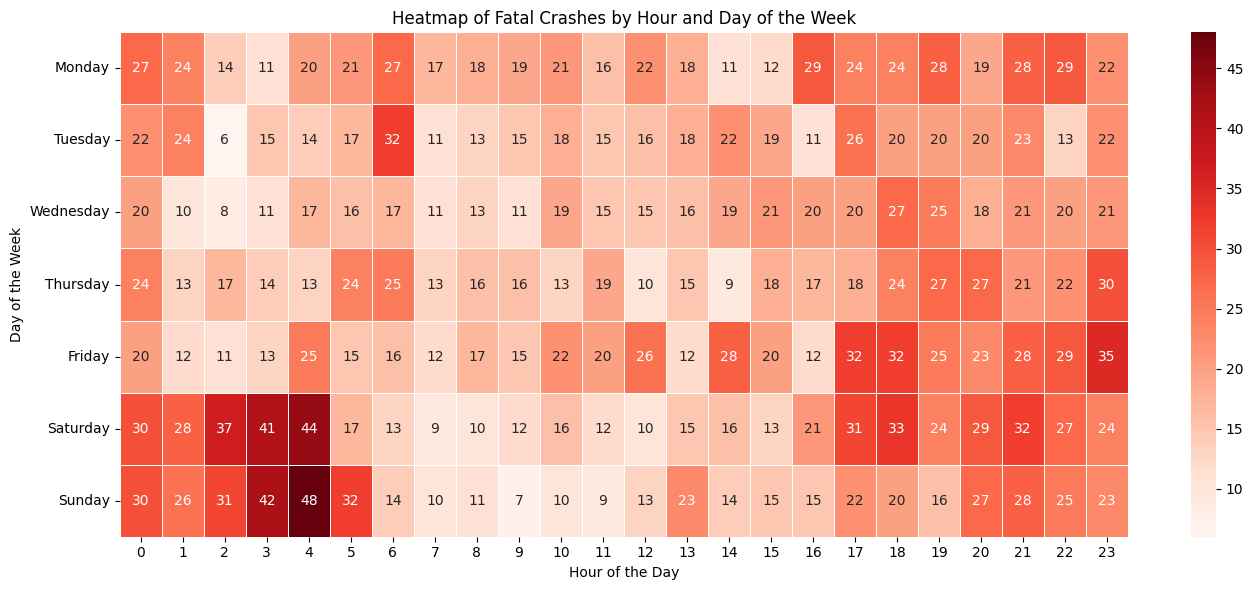

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only rows with valid values
df_heat = df.dropna(subset=['HOUR', 'DAY_OF_WEEK', 'TOTAL_FATALITIES'])
df_heat = df_heat[df_heat['TOTAL_FATALITIES'] > 0]

# Pivot: rows = Day, columns = Hour (like your image)
heatmap_data = df_heat.pivot_table(
    index='DAY_OF_WEEK',
    columns='HOUR',
    values='TOTAL_FATALITIES',
    aggfunc='sum',
    fill_value=0
)

# Reorder day rows to proper order (Mon–Sun)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Plot with styling
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, annot=True, fmt='.0f')
plt.title("Heatmap of Fatal Crashes by Hour and Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.tight_layout()
plt.show()


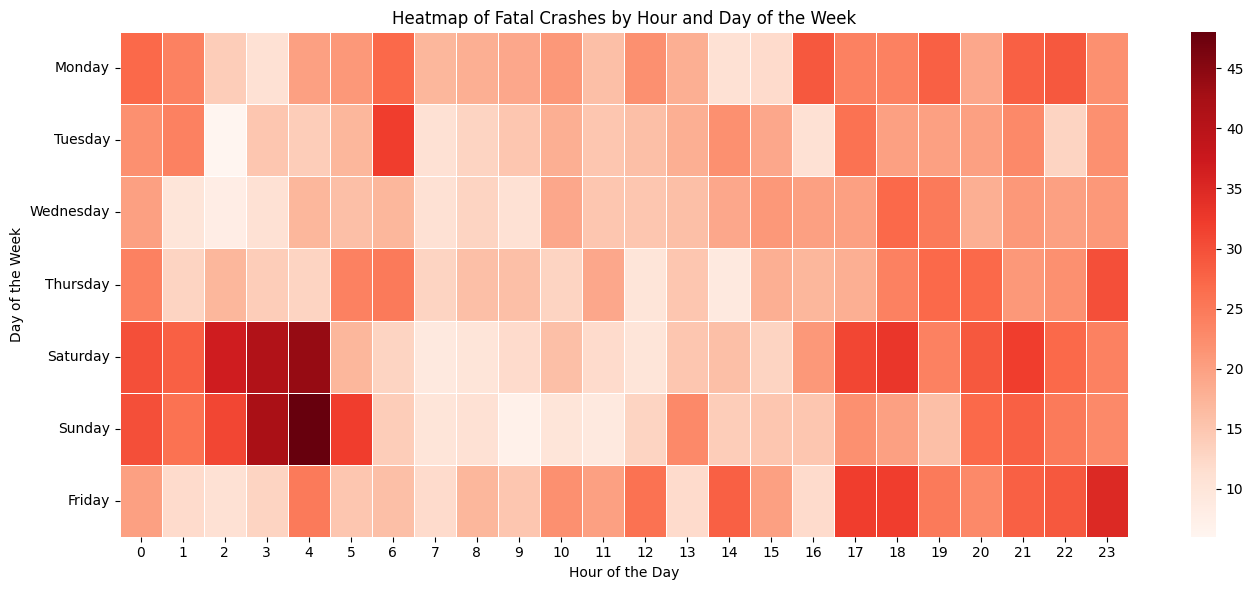

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_heat = df.dropna(subset=['HOUR', 'DAY_OF_WEEK', 'TOTAL_FATALITIES'])
df_heat = df_heat[df_heat['TOTAL_FATALITIES'] > 0]

# Create pivot (rows = Day, cols = Hour)
heatmap_data = df_heat.pivot_table(
    index='DAY_OF_WEEK',
    columns='HOUR',
    values='TOTAL_FATALITIES',
    aggfunc='sum',
    fill_value=0
)

# Reorder: Put Sat and Sun in the middle
custom_day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday', 'Friday']
heatmap_data = heatmap_data.reindex(custom_day_order)

# Plot without numbers
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, annot=False)
plt.title("Heatmap of Fatal Crashes by Hour and Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.tight_layout()
plt.show()


In [134]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Filter fatal crashes with valid coordinates
fatal_df = df[(df['TOTAL_FATALITIES'] > 0) & df['LATITUDE'].notna() & df['LONGITUDE'].notna()]

# Create map centered on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='OpenStreetMap')

# Add marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add points to the cluster
for _, row in fatal_df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color='red',
        fill=True,
        fill_color='orange',
        fill_opacity=0.6,
        popup=f"Fatalities: {int(row['TOTAL_FATALITIES'])}"
    ).add_to(marker_cluster)

# Save as HTML file
m.save("nyc_fatality_clusters.html")


In [135]:
from google.colab import files
files.download("nyc_fatality_clusters.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
from scipy.stats import ttest_ind
import pandas as pd

# Step 1: Normalize column names (important!)
df.columns = df.columns.str.strip().str.upper().str.replace(" ", "_")

# Step 2: Parse CRASH_TIME and extract hour
df['CRASH_HOUR'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce').dt.hour

# Step 3: Drop rows with missing time or fatality data
df_valid = df.dropna(subset=['CRASH_HOUR', 'NUMBER_OF_PERSONS_KILLED'])

# Step 4: Create IS_NIGHT flag (1 = night: 0 to 6)
df_valid['IS_NIGHT'] = df_valid['CRASH_HOUR'].between(0, 6).astype(int)

# Step 5: Separate into groups
night_fatalities = df_valid[df_valid['IS_NIGHT'] == 1]['NUMBER_OF_PERSONS_KILLED']
day_fatalities = df_valid[df_valid['IS_NIGHT'] == 0]['NUMBER_OF_PERSONS_KILLED']

# Step 6: Run independent T-test (Welch’s test)
t_stat, p_value = ttest_ind(night_fatalities, day_fatalities, equal_var=False)

# Step 7: Output results
print("T-statistic:", round(t_stat, 4))
print("P-value:", round(p_value, 4))

if p_value < 0.05:
    print("✅ Reject the null hypothesis: Fatal crashes are more likely at night.")
else:
    print("❌ Fail to reject the null hypothesis: No significant difference between night and day.")


<ipython-input-137-0a34d6057ab6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['IS_NIGHT'] = df_valid['CRASH_HOUR'].between(0, 6).astype(int)


T-statistic: 19.9136
P-value: 0.0
✅ Reject the null hypothesis: Fatal crashes are more likely at night.


<ipython-input-138-141f41123c1e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['IS_NIGHT'] = df_valid['CRASH_HOUR'].between(0, 6).astype(int)
<ipython-input-138-141f41123c1e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_fatalities, x='TIME_PERIOD', y='NUMBER_OF_PERSONS_KILLED', palette='Reds')


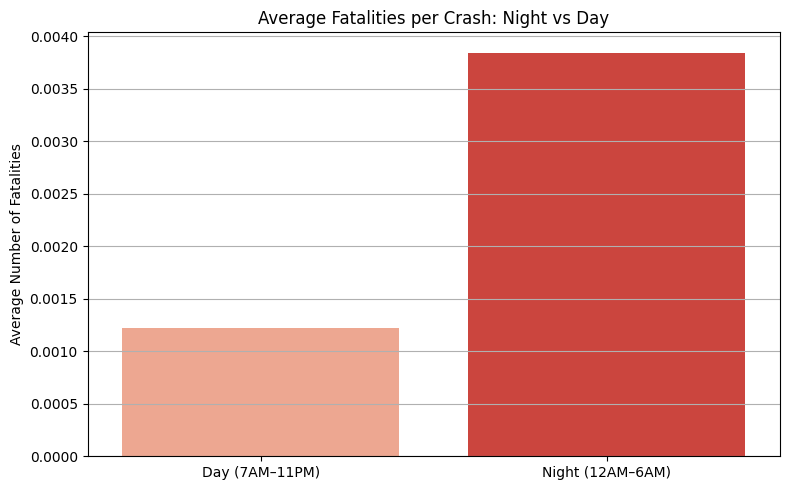

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Normalize column names again if needed
df.columns = df.columns.str.strip().str.upper().str.replace(" ", "_")

# Step 2: Extract hour from CRASH_TIME
df['CRASH_HOUR'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce').dt.hour

# Step 3: Drop rows with missing time or fatality data
df_valid = df.dropna(subset=['CRASH_HOUR', 'NUMBER_OF_PERSONS_KILLED'])

# Step 4: Create IS_NIGHT flag
df_valid['IS_NIGHT'] = df_valid['CRASH_HOUR'].between(0, 6).astype(int)

# Step 5: Calculate average fatalities
avg_fatalities = df_valid.groupby('IS_NIGHT')['NUMBER_OF_PERSONS_KILLED'].mean().reset_index()
avg_fatalities['TIME_PERIOD'] = avg_fatalities['IS_NIGHT'].map({0: 'Day (7AM–11PM)', 1: 'Night (12AM–6AM)'})

# Step 6: Plot
plt.figure(figsize=(8,5))
sns.barplot(data=avg_fatalities, x='TIME_PERIOD', y='NUMBER_OF_PERSONS_KILLED', palette='Reds')
plt.title("Average Fatalities per Crash: Night vs Day")
plt.ylabel("Average Number of Fatalities")
plt.xlabel("")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
